Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

# PSI3471 - Aula de Exercícios 02 

# Algoritmo LMS e modos de treinamento

Neste exercício vamos utilizar o algoritmo LMS no problema de classificação das meias-luas considerando os modos de treinamento estocástico, batch e mini-batch.

Iniciamos importando as bibliotecas necessárias para implementar o algoritmo LMS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vamos gerar os dados de treinamento do problema das meias-luas.

In [2]:
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    Nt = NA + NB  # total de dados de treinamento

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    xA = rxy * np.cos(a)
    yA = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((xA, yA, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    xB = rxy * np.cos(a) + r1
    yB = -rxy * np.sin(a) - r2
    dB = -np.ones((NB, 1))
    pontosB = np.hstack((xB, yB, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(xA, yA, ".b")
    ax1.plot(xB, yB, ".r")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

Gera dados de treinamento

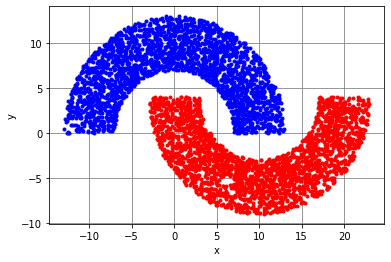

In [3]:
NA = 2500
NB = 2500
Nt = NA + NB  # número de dados de treinamento
r1 = 10
r3 = 6
r2 = -4

dados_treino = meias_luas(NA, NB, r1, r2, r3)

In [4]:
# organizando os dados para entrada do LMS
x = dados_treino[:, [0, 1]]  # sinal de entrada
d = dados_treino[:, [2]]  # sinal desejado

## **Solução de Wiener** 

A função abaixo calcula a Solução de Wiener. Novamente, não é usual considerar um bias, mas como vamos inserir isso no LMS, vamos fazer o mesmo aqui.

<div class="alert alert-block alert-success">
Complete o código a seguir:
</div>

In [52]:
# Função que obtém a solução de Wiener
def Wiener(x, d, Nt):
    """
    W_Wiener = Wiener(x,d,M,Nt)
    x: sinal de entrada
    d: sinal desejado
    Nt: número de dados de treinamento
    """
    M = x.shape[1]
    R = np.zeros((M + 1, M + 1))
    p = np.zeros((M + 1, 1))
    # inserimos uma coluna de uns ao vetor de entrada para levar em conta o bias
    x = np.hstack((np.ones((Nt, 1)), x))
       
    for i in range(Nt):
        xM = x[i, :].reshape(-1, 1) #transforma vetor linha pra vetor coluna
        #############        
        R = R + (xM @ xM.T)
        p = p + d[i,0]*xM
        #############
  
    R = R / Nt
    p = p / Nt
    W_Wiener = np.linalg.solve(R, p)

    return W_Wiener

In [53]:
Ww = Wiener(x, d, Nt)
print(Ww)

[[-0.12011601]
 [-0.02720106]
 [ 0.12566367]]


## **Modo estocástico** 

<div class="alert alert-block alert-success">
Complete o código a seguir:
</div>

In [62]:
# Função que implementa o algoritmo LMS no modo de treinamento estocástico
def LMS_FILTER_estocastico(x, d, eta, Nt):
    """
    y,e,W = LMS_FILTER_estocastico(x,d,eta,M,Nt)
    x: sinal de entrada
    d: sinal desejado
    eta: passo de adaptação
    Nt: número de dados de treinamento
    """
    M = x.shape[1]
    W = np.zeros((Nt + 1, M + 1))
    # inserimos uma coluna de uns ao vetor de entrada para levar em conta o bias
    x = np.hstack((np.ones((Nt, 1)), x))
    for i in range(Nt):
        #############
        # Note que o índice i usado no site inicia em 1
        y = (x[i,:].T) @ W[i,:] 
        e = d[i,0] - y
        W[i + 1, :] = W[i,:] + eta*e*x[i,:]
        #############       
    return W

Algumas observações:
 

*   Em filtragem adaptativa, é comum considerar uma linha de atrasos no sinal de entrada, como foi explicado no material sobre o algoritmo LMS. No entanto, para a aplicação de classificação considerada aqui, não faz sentido considerar uma linha de atrasos.
*   Também não é usual inserir o bias ao sinal de entrada como fizemos aqui.
*   Inserimos o bias aqui porque estamos interessados em usar o algoritmo LMS como um modelo de um neurônio linear.



Precisamos definir o passo de adaptação e número de pesos. No caso, vamos considerara M=2 já que temos um vetor de tamanho 2 na entrada do algoritmo.

In [63]:
eta = 1e-3  # passo de adaptação do LMS
We = LMS_FILTER_estocastico(x, d, eta, Nt)

Mostra no mesmo gráfico gráfico dos pesos e bias do algoritmo LMS e da solução de Wiener.

Text(0.5, 1.0, 'Pesos do LMS (em preto) e pesos da Solução em Wiener (em vermelho tracejado)')

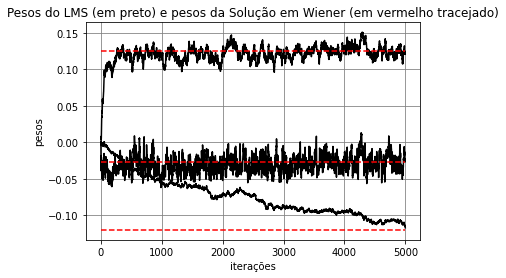

In [64]:
# Mostra os pesos ao longo do treinamento
# Obtém a solução de Wiener e plota junto com os pesos
plt.plot(We, "k", label="LMS")
plt.plot(
    [0, Nt],
    [Ww[0], Ww[0]],
    "r--",
    [0, Nt],
    [Ww[1], Ww[1]],
    "r--",
    [0, Nt],
    [Ww[2], Ww[2]],
    "r--",
    label="Wiener",
)
plt.xlabel("iterações")
plt.ylabel("pesos")
plt.grid(axis="x", color="0.5")
plt.grid(axis="y", color="0.5")
plt.title(
    "Pesos do LMS (em preto) e pesos da Solução em Wiener (em vermelho tracejado)"
)

## **Reta de separação** 

Vamos gerar dados de teste e verificar como é feita a separação com a solução de Wiener.

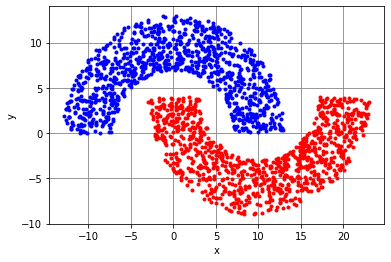

In [65]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt
r1 = 10
r3 = 6
r2 = -4

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

In [66]:
# Inserindo 1's no vetor de entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada
b = np.ones((Nteste, 1))
xteste = np.hstack((b, xteste))
dteste = dados_teste[:, 2].reshape(-1, 1)  # sinal desejado
yteste = xteste @ Ww  # saída do filtro de Wiener considerando os dados de teste

In [67]:
# Gera a reta de separação das duas regiões
# Dados da reta de separação
xS1 = -15 * np.ones((Nteste, 1))  # cosidera x=-15

# varia y no intevalo [-10, 15]
yS1 = np.linspace(-10, 15, Nteste).reshape(-1, 1)

pontosS1 = np.hstack((b, xS1, yS1))

# saída da solução de Wiener considerando os dados de entrada pontosS1
ysep1 = pontosS1 @ Ww

# descobre a posição do mínimo
ind1 = np.where(np.absolute(ysep1) == np.min(np.absolute(ysep1)))[0]

xS2 = 25 * np.ones((Nteste, 1))  # considera  x=25

# varia y no intevalo [-10, 15]
yS2 = np.linspace(-10, 15, Nteste).reshape(-1, 1)

pontosS2 = np.hstack((b, xS2, yS2))

# saída do filtro fixo considerando os dados de entrada pontosS2
ysep2 = pontosS2 @ Ww

# descobre a posição do mínimo
ind2 = np.where(np.absolute(ysep2) == np.min(np.absolute(ysep2)))[0]

Text(0, 0.5, 'y_teste')

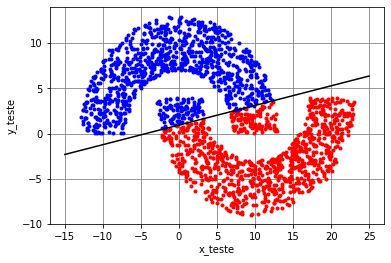

In [68]:
# mostra os dados de teste, o resultado da classificação e a reta de separação
fig, ax2 = plt.subplots()
for i in range(Nteste):
    if yteste[i] > 0:
        ax2.plot(xteste[i, 1], xteste[i, 2], ".b")
    else:
        ax2.plot(xteste[i, 1], xteste[i, 2], ".r")

pontoS1 = pontosS1[ind1, [1, 2]].reshape(-1, 1)
pontoS2 = pontosS2[ind2, [1, 2]].reshape(-1, 1)
ax2.plot([pontoS1[0], pontoS2[0]], [pontoS1[1], pontoS2[1]], "k")
plt.grid(axis="x", color="0.5")
plt.grid(axis="y", color="0.5")
plt.xlabel("x_teste")
plt.ylabel("y_teste")

<div class="alert alert-block alert-success">
Complete o código a seguir:
</div>

In [103]:
#############  
# numero real em [-1,1] -> -1 ou 1 -> vetorClassificador
# comparo vetorClassificador com d -> erros = (d-vetorClassificador)
# taxaErros = erros/total     
#Taxa_de_erro =  
#############

#Extraindo dTeste
dt = dados_teste[:,2]

  #Classificacao
vetorClassificador = []

for i in range(Nteste):
    if yteste[i] > 0:
        vetorClassificador.append(1) 
    else:
        vetorClassificador.append(-1) 

   #Comparacao
erros = dt - vetorClassificador   

numeroDeErros = np.where(erros == 0)[0]
numeroDeErros = numeroDeErros.size

  #Taxa
Taxa_de_erro = 1 - numeroDeErros/erros.size

print(f"Taxa de erro: {Taxa_de_erro}")

Taxa de erro: 0.10650000000000004


<div class="alert alert-block alert-success">
Complete o código a seguir:
</div>

Plote um gráfico com a reta de separação, considerando os valores dos pesos da última iteração em vez dos valores obtidos pela solução de Wiener. Note que o `yteste` deve ser recalculado com os últimos valores de `We`.

In [ ]:
#############



#############

## **Modo batch** 

Vamos modificar a função anterior para considerar o modo de treinamento batch.

<div class="alert alert-block alert-success">
Complete o código a seguir:
</div>

In [ ]:
def LMS_FILTER_batch(x, d, eta, Nt, Ne):
    """
    W = LMS_FILTER_batch(x,d,eta,M,Nt)
    x: sinal de entrada
    d: sinal desejado
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Ne: número de épocas
    """
    """
    No modo de treinamento batch, é conveniente juntar o sinal de entrada e o sinal 
    desejado em um único vetor, uma vez que a cada época vamos embaralhar os dados.
    Ao fazer isso, já inserimos uma coluna de 1's para levar em conta o bias.
    """
    M = x.shape[1]
    Xd = np.hstack((np.ones((Nt, 1)), x, d))
    W = np.zeros((Ne + 1, M + 1))
    # No modo batch, o passo de adaptação é dividido por Nt
    eta = eta / Nt
    for k in range(Ne):
        np.random.shuffle(Xd)
        xb = Xd[:, 0 : M + 1]        
        db = Xd[:, [M + 1]]
        #############
        #eb = 
        #W[[k + 1], :] = 
        #############
    return W

Vamos definir o número de épocas e o passo de adaptação (que agora pode ser um pouco maior) e rodar o algoritmo LMS no modo batch. 

In [ ]:
Ne = 1000
eta = 1e-2
Wb = LMS_FILTER_batch(x, d, eta, Nt, Ne)

A seguir comparamos os pesos obtidos com o LMS no modo batch e os pesos da solução de Wiener.

In [ ]:
# Mostra os pesos ao longo do treinamento e compara com Wiener
plt.plot(Wb, "k", label="LMS")
plt.plot(
    [0, Ne],
    [Ww[0], Ww[0]],
    "r--",
    [0, Ne],
    [Ww[1], Ww[1]],
    "r--",
    [0, Ne],
    [Ww[2], Ww[2]],
    "r--",
    label="Wiener",
)
plt.xlabel("iterações=épocas")
plt.ylabel("pesos")
plt.grid(axis="x", color="0.5")
plt.grid(axis="y", color="0.5")
plt.title(
    "Pesos do LMS no modo batch (em preto) e pesos da Solução em Wiener (em vermelho tracejado)"
)

## **Modo mini-batch** 

Vamos agora modificar a função anterior para considerar o LMS no modo de treinamento mini-batch.

In [ ]:
def LMS_FILTER_minibatch(x, d, eta, Nt, Ne, Nb):
    """
    W = LMS_FILTER_minibatch(x,d,eta,M,Nb)
    x: sinal de entrada
    d: sinal desejado
    eta: passo de adaptação    
    Nt: número de dados de treinamento
    Ne: número de épocas
    Nb: tamanho do mini-batch
    """
    """
    Novamente, vamos juntar o sinal de entrada e o sinal desejado em um único vetor, 
    uma vez que a cada época vamos embaralhar os dados.
    Ao fazer isso, já inserimos uma coluna de 1's para levar em conta o bias.
    """

    M = x.shape[1]
    Nmb = int(np.floor(Nt / Nb))
    W = np.zeros((Ne * Nmb + 1, M + 1))
    Xd = np.hstack((np.ones((Nt, 1)), x, d))

    # No modo mini-batch, o passo de adaptação é dividido por Nb
    eta = eta / Nb
    for k in range(Ne):
        np.random.shuffle(Xd)
        x = Xd[:, 0 : M + 1]
        d = Xd[:, [M + 1]]
        for l in range(Nmb):
            dmb = d[l * Nb : (l + 1) * Nb]
            xmb = x[l * Nb : (l + 1) * Nb, :]
            #############         
            # Note que o índice k usado no site inicia em 1
            #m =
            #emb = 
            #W[[m + 1], :] = 
            #############
    return W

Vamos definir o número de épocas, o passo de adaptação e o tamanho do mini-batch e rodar o algoritmo LMS no modo mini-batch.



In [ ]:
Ne = 100
Nb = 20
eta = 1e-3
Wmb = LMS_FILTER_minibatch(x, d, eta, Nt, Ne, Nb)

A seguir comparamos os pesos obtidos com o LMS no modo mini-batch e os pesos da solução de Wiener.

In [ ]:
# Mostra os pesos ao longo do treinamento e compara com Wiener
Nmb = int(np.floor(Nt / Nb))
print(Nmb)
plt.plot(Wmb, "k", label="LMS")
plt.plot(
    [0, Nmb * Ne],
    [Ww[0], Ww[0]],
    "r--",
    [0, Nmb * Ne],
    [Ww[1], Ww[1]],
    "r--",
    [0, Nmb * Ne],
    [Ww[2], Ww[2]],
    "r--",
    label="Wiener",
)
plt.xlabel("iterações")
plt.ylabel("pesos")
plt.grid(axis="x", color="0.5")
plt.grid(axis="y", color="0.5")
plt.title(
    "Pesos do LMS no modo mini-batch (em preto) e pesos da Solução em Wiener (em vermelho tracejado)"
)

## **Comparando os modos de treinamento** 

Vamos agora plotar o caminho dos pesos no plano $w_1 \times w_2$ ao longo das iterações

In [ ]:
plt.figure()
plt.plot(We[:, 1], We[:, 2], "o-r", label="estocástico")
plt.plot(Wmb[:, 1], Wmb[:, 2], "o-g", label="mini-batch")
plt.plot(Wb[:, 1], Wb[:, 2], "o-b", label="batch")
plt.xlabel("w_1")
plt.ylabel("w_2")
plt.grid(axis="x", color="0.5")
plt.grid(axis="y", color="0.5")
plt.legend()

<div class="alert alert-block alert-success">
Complete o código e faça a análise a seguir:
</div>

Usando diferentes valores para o passo de adaptação (1e-2, 1e-3, 1e-4), avaliem  o comportamento do algoritmo nos modos batch e mini batch, a partir do gráfico de pesos x iterações.

In [ ]:
#############         


#############